In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

2024-10-16 05:57:47.506721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 05:57:47.506891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 05:57:47.643920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data

## Getting

In [2]:
filepaths = []
labels = []

for dirname, _, filenames in os.walk('../data/train'):
    for filename in tqdm(filenames):
        if filename.endswith('.png'):
            filepaths.append(os.path.join(dirname, filename))
            labels.append(dirname.split('/')[-1])

0it [00:00, ?it/s]
100%|██████████| 7215/7215 [00:00<00:00, 392935.19it/s]


In [3]:
fSer = pd.Series(filepaths, name='filepaths')
lSer = pd.Series(labels, name='labels')
train_df = pd.concat([fSer, lSer], axis=1)
train_df.head()

,filepaths,labels
0,/kaggle/input/emotion-detection-fer/train/fear...,fearful
1,/kaggle/input/emotion-detection-fer/train/fear...,fearful
2,/kaggle/input/emotion-detection-fer/train/fear...,fearful
3,/kaggle/input/emotion-detection-fer/train/fear...,fearful
4,/kaggle/input/emotion-detection-fer/train/fear...,fearful


In [4]:
filepaths = []
labels = []

for dirname, _, filenames in os.walk('../data/test'):
    for filename in tqdm(filenames):
        if filename.endswith('.png'):
            filepaths.append(os.path.join(dirname, filename))
            labels.append(dirname.split('/')[-1])

0it [00:00, ?it/s]
100%|██████████| 1774/1774 [00:00<00:00, 369155.35it/s]


In [5]:
fSer = pd.Series(filepaths, name='filepaths')
lSer = pd.Series(labels, name='labels')
test_df = pd.concat([fSer, lSer], axis=1)

## Splitting

In [6]:
valid_df, test_df = train_test_split(test_df, train_size=0.6, shuffle=True, stratify=test_df['labels'])

## Preparing

In [7]:
tr_gen = ImageDataGenerator(
        rescale=1 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
ts_gen = ImageDataGenerator(
    rescale=1 / 255
)

In [8]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 28709 validated image filenames belonging to 7 classes.
Found 4306 validated image filenames belonging to 7 classes.
Found 2872 validated image filenames belonging to 7 classes.


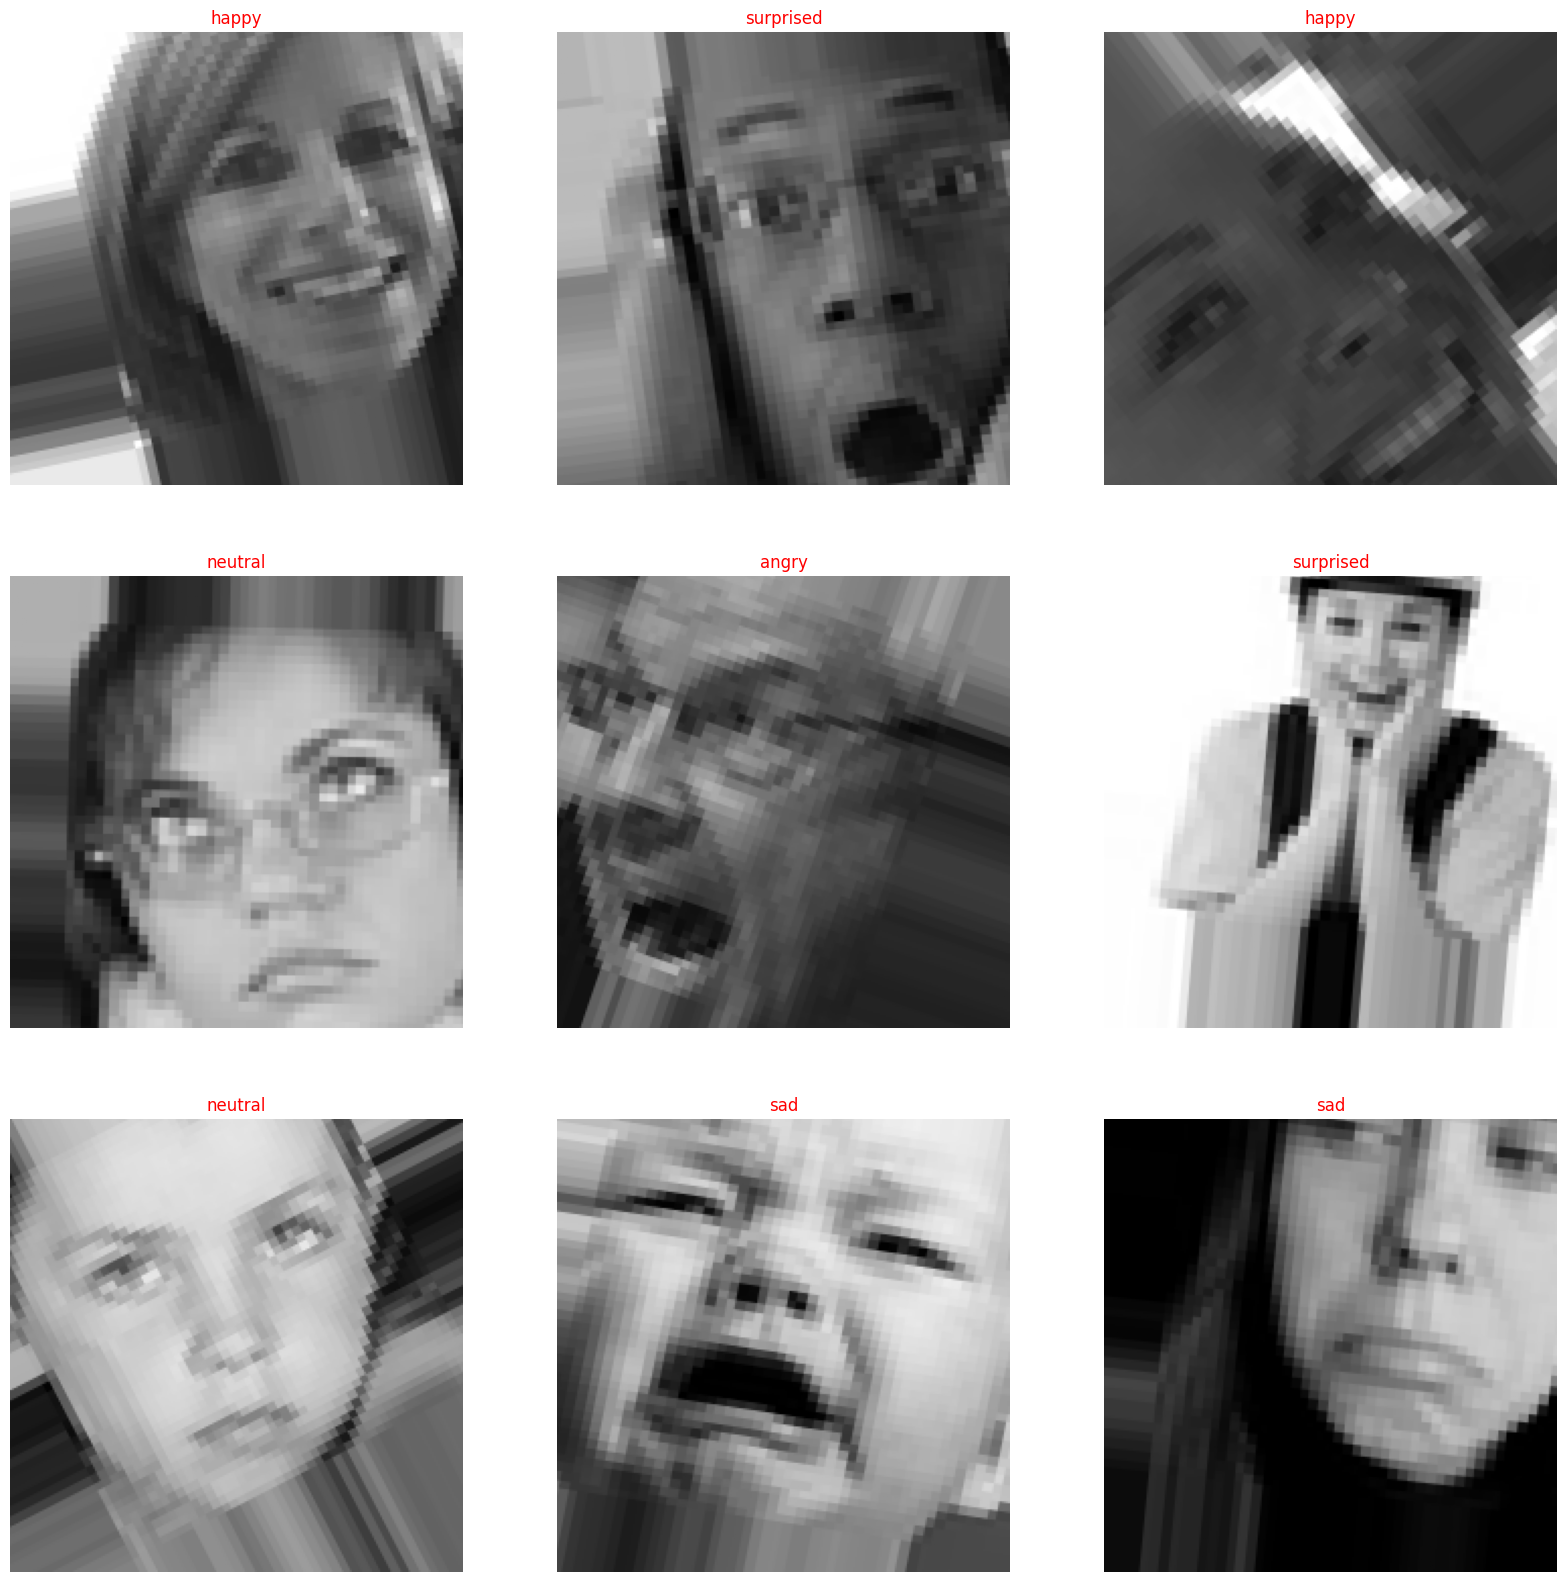

In [9]:
images, labels = next(train_gen)
emotions_dict = train_gen.class_indices
emotions_list = list(emotions_dict.keys())
emotions_count = len(emotions_list)

plt.figure(figsize=(20, 20))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    emotion = emotions_list[np.argmax(labels[i])]
    plt.title(emotion, color='red', fontsize=12)
    plt.axis('off')
plt.show()

# Model

## Structure

In [10]:
inputs = layers.Input(shape=img_shape)

base_model = tf.keras.applications.ResNet50V2(include_top=False, weights=None, input_tensor=inputs)
base_model.load_weights('resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
base_model.trainable = False

x = layers.BatchNormalization()(base_model.output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(emotions_count, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

## Compiling

In [11]:
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

## Training

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_accuracy.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [13]:
classes = np.array(train_gen.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
epochs = 25
steps_per_epoch = 200
validation_steps = 100

history = model.fit(x=train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=valid_gen, validation_steps=validation_steps, callbacks=[checkpoint], class_weight=class_weights_dict)

Epoch 1/25
200/200 [==============================] - 735s 4s/step - loss: 1.8407 - accuracy: 0.2442 - val_loss: 1.7086 - val_accuracy: 0.3297
Epoch 2/25
200/200 [==============================] - 716s 4s/step - loss: 1.6948 - accuracy: 0.3145 - val_loss: 1.6195 - val_accuracy: 0.3834
Epoch 3/25
139/200 [===================>..........] - ETA: 2:18 - loss: 1.6942 - accuracy: 0.3424

### Training results

In [ ]:
epochs_x = [i + 1 for i in range(epochs)]

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

tr_loss, val_loss = history.history['loss'], history.history['val_loss']
index_loss = np.argmin(val_loss)
loss_lowest, loss_label = val_loss[index_loss], f'Best epoch= {str(index_loss + 1)}'
plt.subplot(1, 2, 1)
plt.plot(epochs_x, tr_loss, 'r', label='Training loss')
plt.plot(epochs_x, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, loss_lowest, s=120, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

tr_acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
index_acc = np.argmax(val_acc)
acc_highest, acc_label = val_acc[index_acc], f'Best epoch= {str(index_acc + 1)}'
plt.subplot(1, 2, 2)
plt.plot(epochs_x, tr_acc, 'r', label='Training Accuracy')
plt.plot(epochs_x, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=120, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Testing

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print('Accuracy on test data:', test_acc)

In [ ]:
pred = model.predict_generator(test_gen)
pred = np.argmax(pred, axis=1)
real = test_gen.classes

In [ ]:
cm = confusion_matrix(real, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=classes, yticklabels=emotions_list)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

# Saving

In [ ]:
model.save('model.keras')